<a href="https://colab.research.google.com/github/aydawudu/IAX/blob/main/IAX_CD_Risk_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -r requirements_2.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.4 MB/s eta 0:00:00


### Loading the Libraries

In [4]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Understanding and preparing the data

In [5]:
cvd_df=mldatasets.load("cardiovascular-disease")

https://raw.githubusercontent.com/caravanuden/cardio/master/cardio_train.csv downloaded to /content/data/cardio_train.csv
1 dataset files found in /content/data folder
parsing /content/data/cardio_train.csv


In [6]:
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


### Data Prep

In [7]:
#Lets do feature engineering on the age feature
cvd_df['age']=cvd_df['age']/365.24

In [8]:
#let change the fonts for the headers
def set_header_font():
  return [dict(selector="th", props=[("font-size", "14pt")])]

In [9]:
cvd_df.describe(percentiles=[0.01, .99]).transpose().style.format('{:.2f}').\
              set_properties(**{'font-size': '12pt'}).set_table_styles(set_header_font())

,count,mean,std,min,1%,50%,99%,max
age,70000.00,53.30,6.76,29.56,39.61,53.95,64.31,64.92
gender,70000.00,1.35,0.48,1.00,1.00,1.00,2.00,2.00
height,70000.00,164.36,8.21,55.00,147.00,165.00,184.00,250.00
weight,70000.00,74.21,14.40,10.00,48.00,72.00,117.00,200.00
ap_hi,70000.00,128.82,154.01,-150.00,90.00,120.00,180.00,16020.00
ap_lo,70000.00,96.63,188.47,-70.00,60.00,80.00,1000.00,11000.00
cholesterol,70000.00,1.37,0.68,1.00,1.00,1.00,3.00,3.00
gluc,70000.00,1.23,0.57,1.00,1.00,1.00,3.00,3.00
smoke,70000.00,0.09,0.28,0.00,0.00,0.00,1.00,1.00
alco,70000.00,0.05,0.23,0.00,0.00,0.00,1.00,1.00


In [10]:
##dealing with invalid values like ap_hi and ap_lo since blood pressure cannot be nagative and the max is too high
incorrect_1=cvd_df[
    (cvd_df['ap_hi']>370)
    | (cvd_df['ap_hi']< 40)
    | (cvd_df['ap_lo'] > 370)
    | (cvd_df['ap_lo'] < 40)
    ].index
print(len(incorrect_1) /cvd_df.shape[0])

0.0175


In [11]:
#delete the incorrect values
cvd_df.drop(incorrect_1, inplace=True)

In [12]:
#ap_hi should always be higher than ap_lo, delete anyone that isnt
cvd_df=cvd_df[cvd_df['ap_hi'] >= cvd_df['ap_lo']].reset_index(drop=True)

In [13]:
#make X and y and split into train and test dataset
y=cvd_df['cardio']
X=cvd_df.drop(['cardio'], axis=1).copy()
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, random_state=9)

##Intepretation Method Types and Scopes

In [14]:
#let fit our prepared data into the logistic model
log_model=sm.Logit(y_train, sm.add_constant(X_train))
log_result=log_model.fit()
print(log_result.summary2())

Optimization terminated successfully.
         Current function value: 0.559358
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: cardio           Pseudo R-squared: 0.193     
Date:               2024-01-09 11:51 AIC:              65325.6606
No. Observations:   58372            BIC:              65433.3557
Df Model:           11               Log-Likelihood:   -32651.   
Df Residuals:       58360            LL-Null:          -40457.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------
const         -11.2620   0.2512 -44.8264 0.0000 -11.7544 -10.7695
age             0.0510   0.0015  34.7097 0.0000   0.0482   0.0539


In [15]:
#let's calculate the exponential of these coefficients
np.exp(log_result.params).sort_values(ascending=False)

cholesterol    1.641989
ap_hi          1.057981
age            1.052365
ap_lo          1.011732
weight         1.011346
height         0.996031
gender         0.979808
gluc           0.895285
smoke          0.871416
alco           0.800351
active         0.790225
const          0.000013
dtype: float64

In [16]:
#let calculate the standard devoatopm to provide cotext to the odds
np.std(X_train, 0)

age             6.759016
gender          0.476639
height          8.185228
weight         14.344466
ap_hi          16.677349
ap_lo           9.449287
cholesterol     0.676426
gluc            0.570190
smoke           0.282152
alco            0.223393
active          0.397624
dtype: float64

In [17]:
# to obtain features that matters the most, one way to approximate is to multiply the cooficients by the std. deviation
coefs=log_result.params.drop(labels=['const', 'gender']) #drop the constant values and gender with high p-value
stdv=np.std(X_train, 0).drop(labels='gender')
abs(coefs * stdv).sort_values(ascending=False)

ap_hi          0.939968
age            0.344981
cholesterol    0.335445
weight         0.161829
ap_lo          0.110217
active         0.093616
gluc           0.063070
alco           0.049751
smoke          0.038834
height         0.032548
dtype: float64

## Intepreting Individual Predictions with Logistic Regression

In [19]:
#let using out model to predict the entire test dataset
y_pred=log_result.predict(sm.add_constant(X_test)).to_numpy()
print(y_pred)

[0.61799612 0.48549555 0.43570271 ... 0.27796102 0.62210177 0.54744385]


In [24]:
# prompt: print values index greater than 0.5

pos_cases= np.where(y_pred > 0.5)[0]


In [29]:
# prompt: select a random from values

rand_case=np.random.choice(pos_cases)
print(rand_case)


801


In [35]:
#let check out its prediction for the random value
print(y_pred[rand_case])

0.926475645455185


In [32]:
#print the details of the random case
print(X_test.iloc[rand_case])

age             50.566751
gender           1.000000
height         162.000000
weight          79.000000
ap_hi          160.000000
ap_lo           90.000000
cholesterol      3.000000
gluc             3.000000
smoke            0.000000
alco             0.000000
active           1.000000
Name: 15096, dtype: float64


- According to the American Heart Association, a ap_hi above 130 is considered high, so in our case the ap_hi is high
- An ap_lo of 90 or above is deemed high
- Age is not old
- Choresteroal is also above normal
- Weight is more than the healthy zone
Which explains why the prediction is positive


In [39]:
# prompt: print value index greater than 0.5 but less than 0.6

print(np.random.choice(np.where((y_pred > 0.5) & (y_pred < 0.6))[0]))


8648


In [40]:
#let's explore a less clearer prediction
print(y_pred[8648])

0.5771218439219377


In [41]:
#print the details
print(X_test.iloc[8648])

age             58.654583
gender           1.000000
height         153.000000
weight          80.000000
ap_hi          130.000000
ap_lo           90.000000
cholesterol      1.000000
gluc             3.000000
smoke            0.000000
alco             0.000000
active           1.000000
Name: 5932, dtype: float64


- A borderline ap_hi at 130
- A borderline ap_lo at 90
- The glucose is above normal  and weight and height indicate obesity
- Choresterol  is normal and age is not too old

There are some risk factors presented but lets put prediction in context of predicitons for every single feature using a decision boundry chart

We will visualize two decision based features while holding other features constant, so observe the two in isolation. We will achieve this by filling other features with calues that wont affect the outcome ( A lower value is ledd risky for CVD). Eg age 30 is less risky value

In [42]:
filler_feature_values = {"age": 30, "gender": 1, "height": 165, "weight": 57, "ap_hi": 110,
                         "ap_lo": 70, "cholesterol": 1, "gluc": 1, "smoke": 0, "alco":0, "active":1
                    }

In [43]:
#create a (1,12) shaped Numpy Array for case 8648, and prepend the constant of 1 because of statsmodels where we have to explicity define the intercept then we reshape
X_highlight=np.reshape(
    np.concatenate(([1], X_test.iloc[8648].to_numpy())), (1, 12)
)
print(X_highlight)

[[  1.          58.65458329   1.         153.          80.
  130.          90.           1.           3.           0.
    0.           1.        ]]


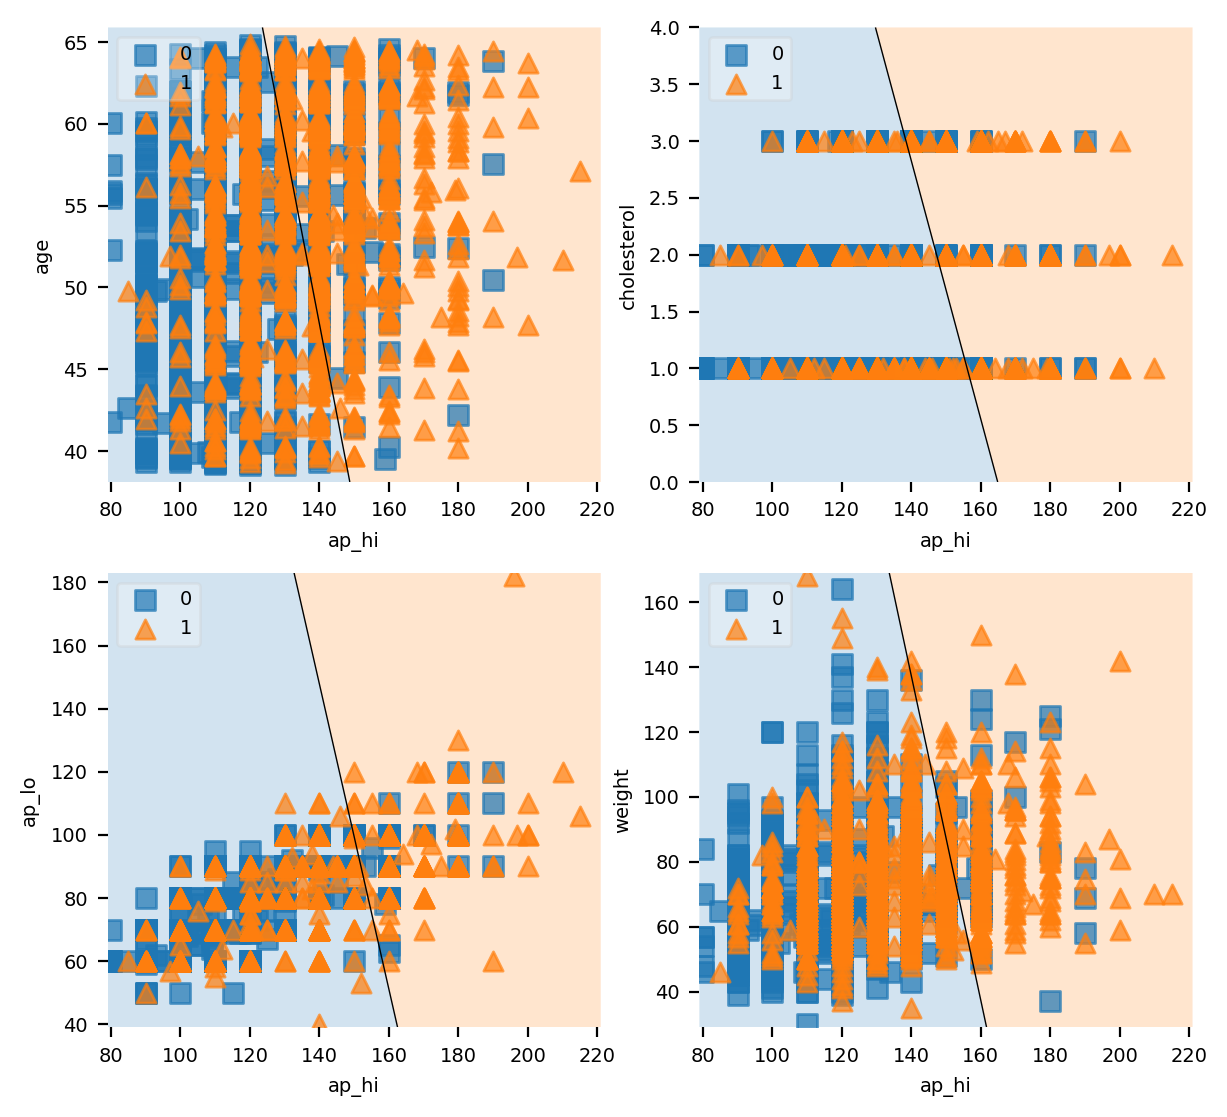

In [48]:
#let's visualize some desicion region plots for the four most important risk factors : age, cholesterol, weight, ap_lo
plt.rcParams.update({'font.size':7, 'figure.dpi':200})
fig, axarr=plt.subplots(2,2, figsize=(7, 5), sharex=True, sharey=False)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi", "age"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[0]
)

mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi", "cholesterol"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[1]
)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi", "ap_lo"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[2]
)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi", "weight"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[3]
)
plt.subplots_adjust(top=1, bottom=0, hspace=0.2, wspace=0.2)
plt.show()

### what Hinders Machine Learning Interpretability

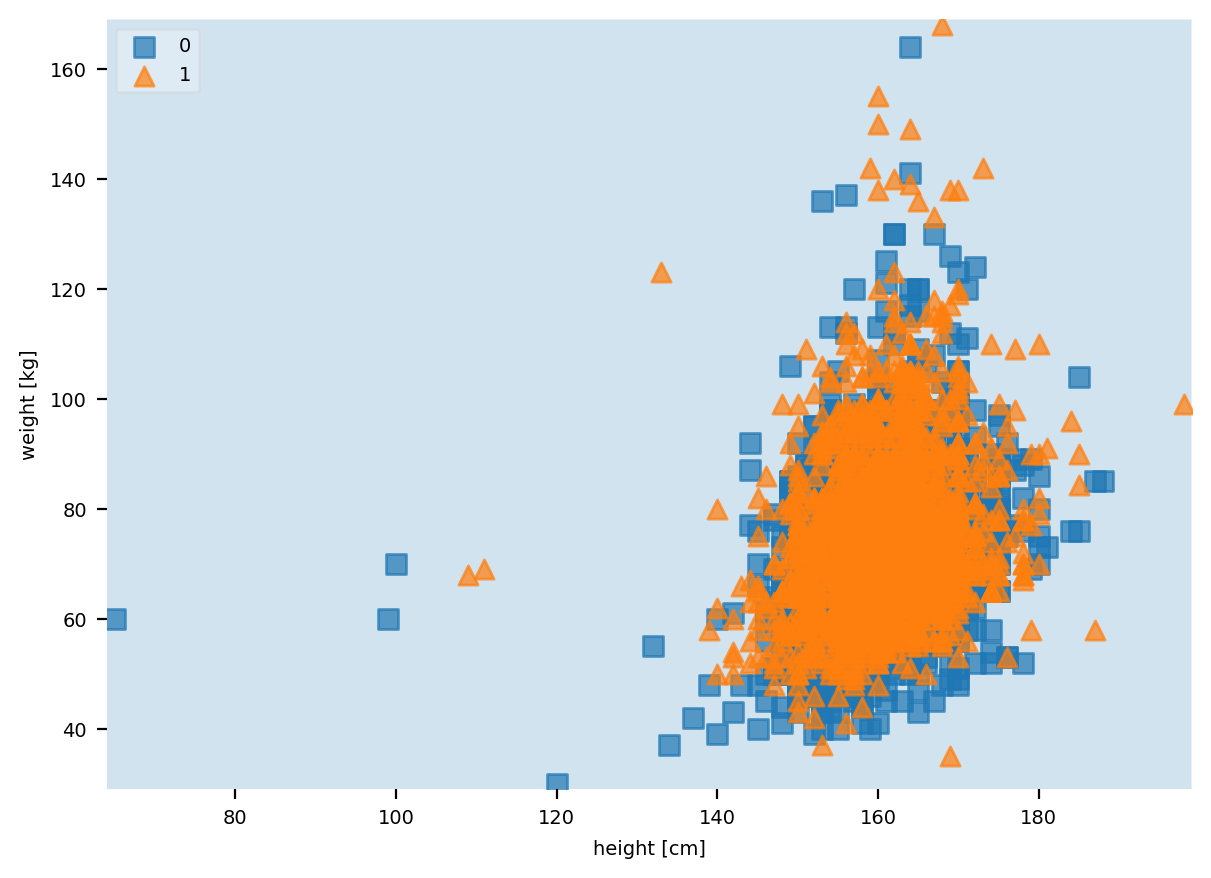

In [51]:
##Sometimes there might be mediating variables that influences the strength between independent and the target variable
#eg weight and height
fig, ax=plt.subplots(1,1, figsize=(7,5))
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    [3,4],
    ['height [cm]',
     'weight [kg]'],
    X_highlight,
    filler_feature_values,
    ax=ax
)
plt.show()

There is no decision boundary because no combination of heights and weight is enough to predict CVD but we notice the oval shaped area show the interaction between weight and height. BMI can be used to explain this relationship.

Three main factors that increases complexity are
- Non-linearity
- Interactivity
- Non-monotonicity

In [53]:
## Non-linearity can be solved by used a non-linear model or engineering a feature that linearize the model. Eg use BMI to attempt to lineaeize
X2=cvd_df.drop(['cardio'], axis=1).copy()
X2["bmi"]=X2["weight"]/(X2["height"]/100)**2

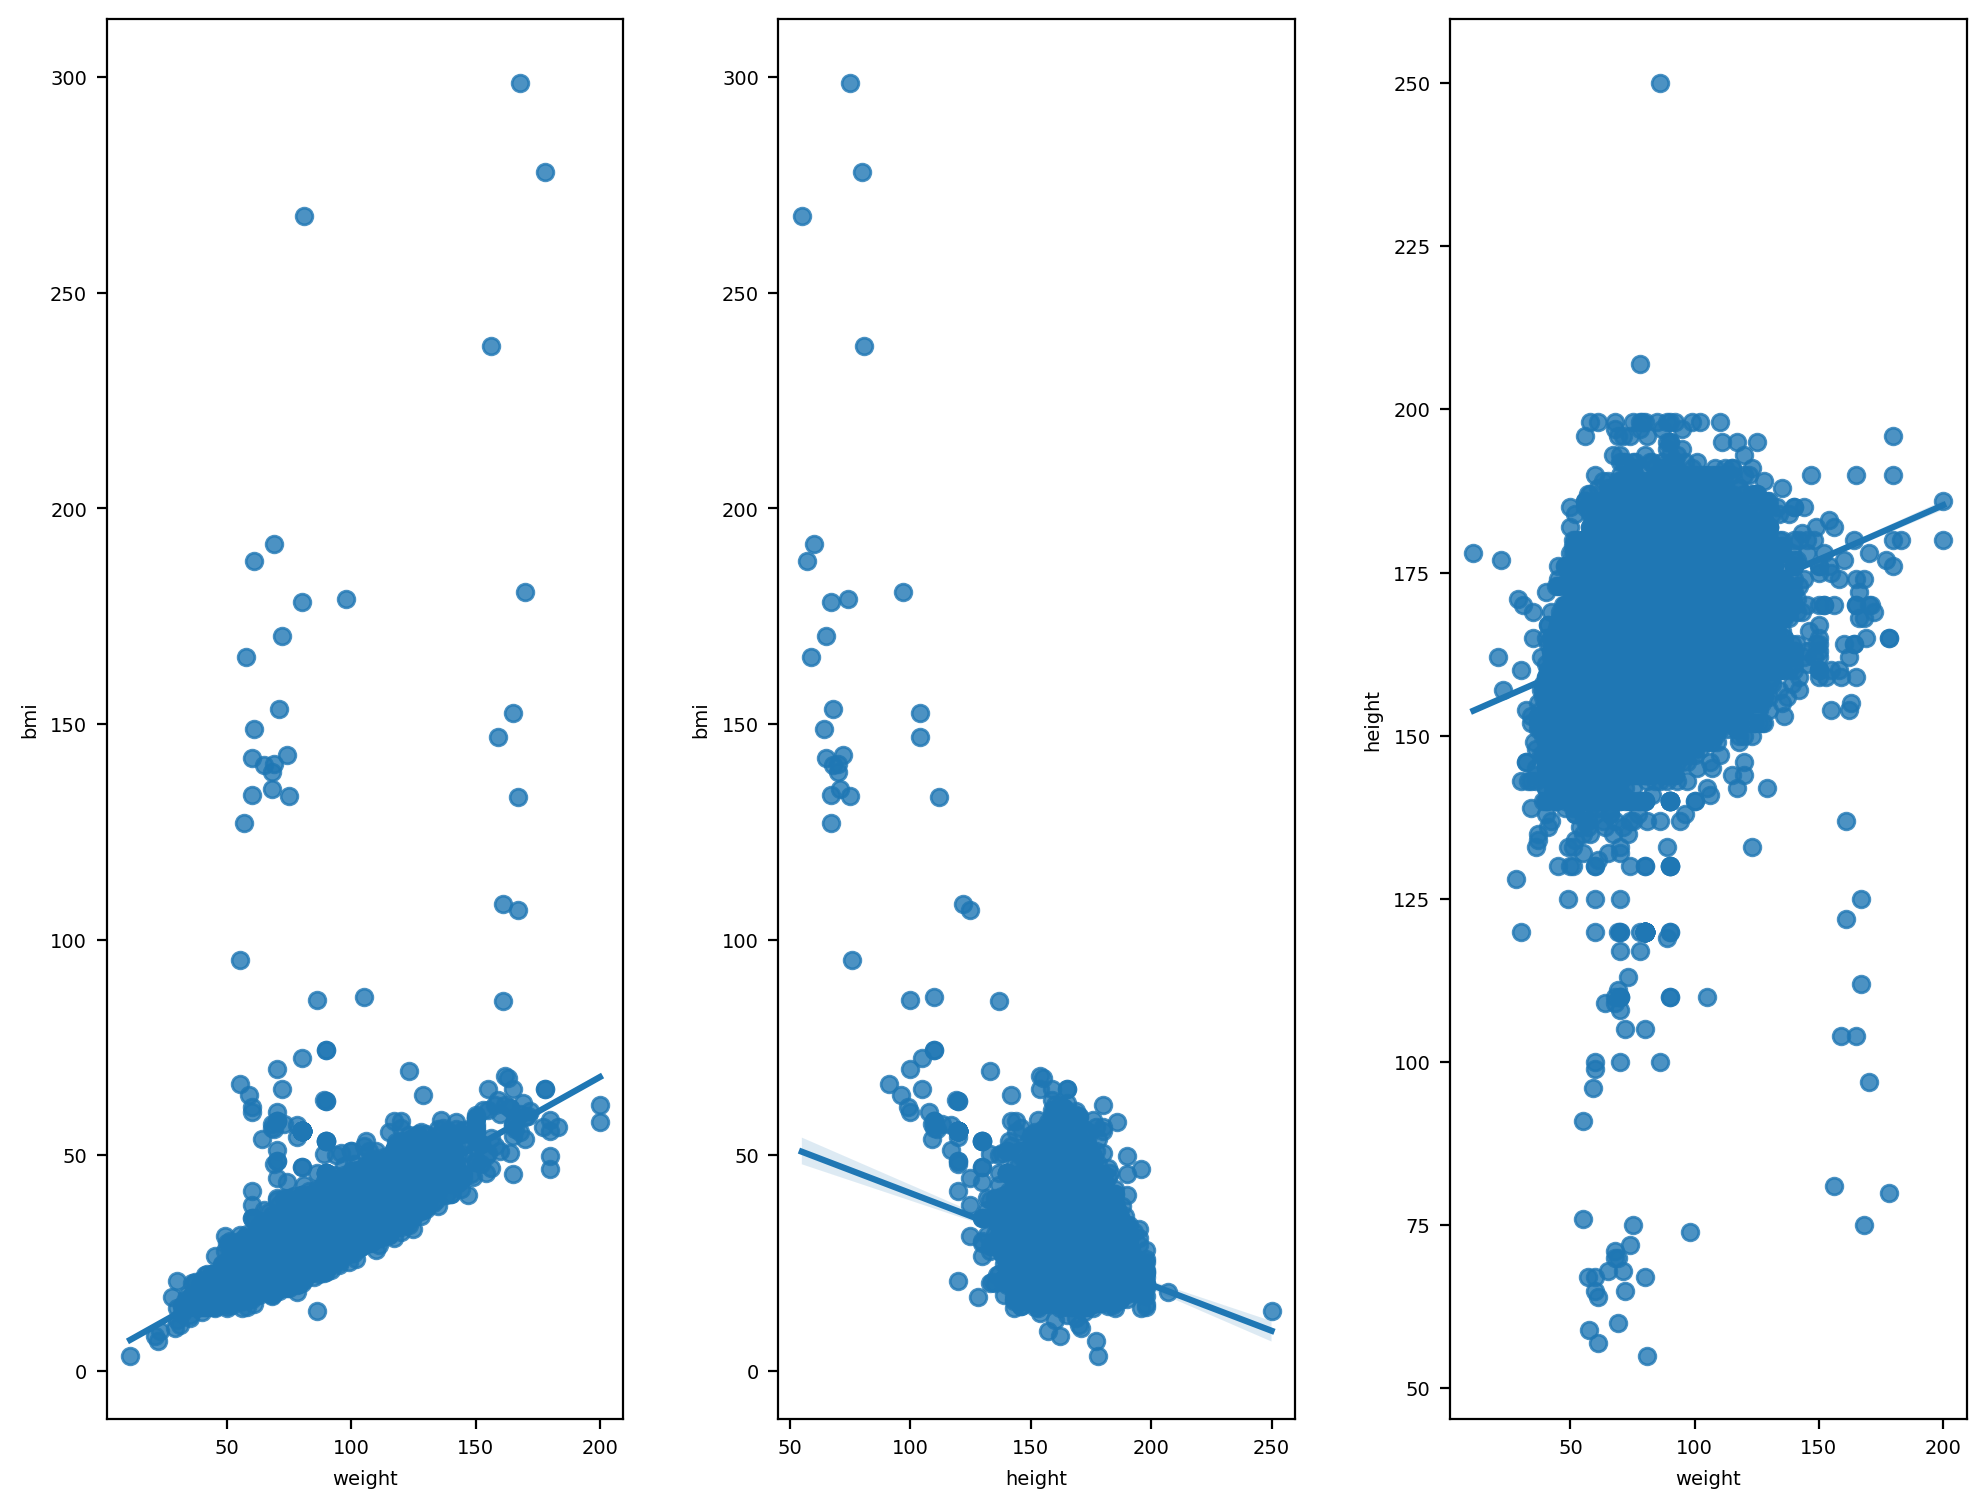

In [54]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3, figsize=(12, 7))
sns.regplot(x="weight", y="bmi", data=X2, ax=ax1)
sns.regplot(x="height", y="bmi", data=X2, ax=ax2)
sns.regplot(x="weight", y="height", data=X2, ax=ax3)
plt.subplots_adjust(top=1, bottom=0, hspace=0.2, wspace=0.3)
plt.show()

In [55]:
# let's fit a new model using the extra feature
X2 = X2.drop(['weight','height'], axis=1)
X2_train, X2_test, _, _ = train_test_split(X2, y, test_size=0.15, random_state=9)
log_model2 = sm.Logit(y_train, sm.add_constant(X2_train))
log_result2 = log_model2.fit()

Optimization terminated successfully.
         Current function value: 0.559942
         Iterations 6


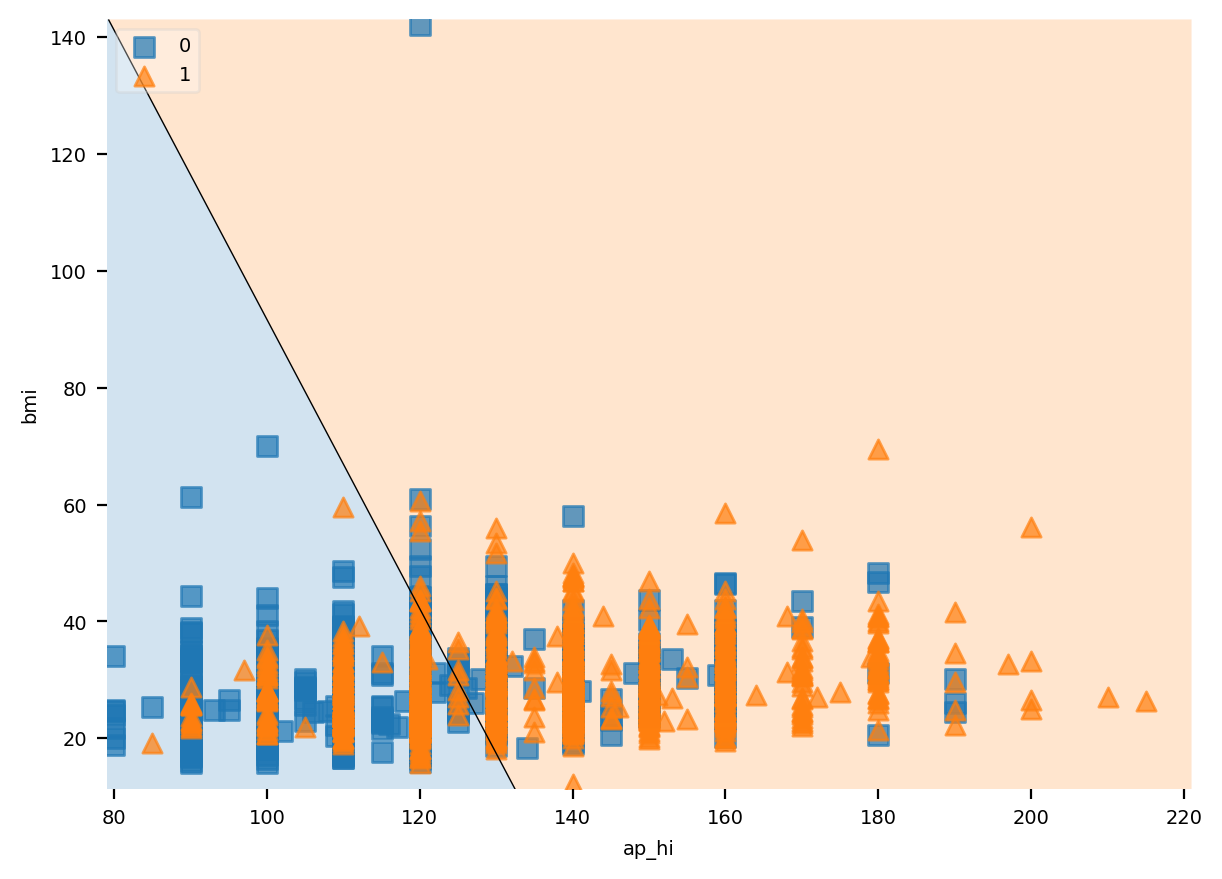

In [57]:
# let test our selected case to see if
filler_feature_values2 = {"age": 60, "gender": 1, "ap_hi": 110, "ap_lo": 70, "cholesterol": 1, "gluc": 1,\
                          "smoke": 0, "alco":0, "active":1, "bmi":20}
X2_highlight = np.reshape(np.concatenate(([1],X2_test.iloc[8648].to_numpy())), (1, 11))

fig, ax = plt.subplots(1,1, figsize=(7,5))
mldatasets.create_decision_plot(X2_test, y_test, log_result2, ["ap_hi", "bmi"], None,
                     X2_highlight, filler_feature_values2, ax=ax)
plt.show()